# To Buy or Not to Buy: How IPO "Hype" Correlates with Market Success of a Company

## Overview

This study investigates the correlation between the IPO "hype" a company experiences and how well the company performs on the stock market in its first eight months. IPO hype, as we have defined it here, is the percent increase in price the stock experiences from its opening price on the day of the IPO to its opening price on the next day. Performance is defined by the percent change from opening price of the company's stock on the day after IPO to the opening price on the day after the last day of the specified time period after it goes public. The results indicate that initial hype does not correlate with the company's stock price at the end of any of the time periods investigated; thus, investors should not assume that greater IPO hype is a predictor of the company's future success. These results are significant in that they inform public decisions regarding whether or not it is advisable to invest in a new company that performs considerably well on its first day of public trading on the stock market.

## Names

- Akshatha Silas
- Robert Ramji
- Tejas Sriram
- Yu Ken Yu

## Research Question

Is the IPO hype a company experiences a reliable and/or strong predictor of the company's stock market performance over the first eight months? IPO hype (the independent variable) is operationalized as the percent increase in stock price for the company's first day public. Eight-month stock performance (the dependent variable) is operationalized as the percent gain or loss from Day 0 opening price to Day 241 opening price.

## Background and Prior Work
An IPO is an initial Public Offering where a company launches on to the public stock market by offering their shares that represent a part ownership in the company. An IPO allows for the public to buy and sell their shares, which leads to fluctuations in daily price.

Before a company goes public, it generally has to carve out a place on the market by making itself known though public advertising and positive mentions in financial news networks. This preparation can be considered the company's IPO "hype," and for the purposes of this study, is quantified by its direct result: how well the stock performs on its first day public. 

However, it is not known with certainty if companies with strong IPO hype actually end up performing better on the stock market, at least during their first eight months, than their lesser hyped counterparts. For example, the company Beyond Meat came out on NASDAQ on May 2019 and enjoyed a very successful first day, starting at 25 USD and closing at 65.75 USD (a gain of 163%). The company reached a high of 234, and then fell to 110 USD by the end of the eight-month period (still a net gain of around 400%). Another company, Shineco Inc., experienced an even more impressive gain on its first day, starting at 7 USD and going up to 21 USD (300%). However, by the end of the eighth month, the stock price had fallen to a dismal 51% of its opening value, ending at only 3.28 USD.

Social expectations play an important role in the success or failure of a stock, and even of the stock market in general. While plenty of studies have looked at how stock anticipation relates to first-day stock performance, the anomalies above interested us in how IPO hype affects the performance of a company's stock in the slightly longer term. People may be inclined to purchase stocks that perform well on their first day, expecting that the price will continue to increase. This study analyzes whether such consumer behavior is rooted in any actual evidence by checking for a predictive correlation between IPO hype and a company's stock market performance at the eight-month mark.

References
- https://markets.businessinsider.com/news/stocks/5-most-important-factors-for-successful-ipo-performance-goldman-sachs-2019-9-1028507003#sales-growth5
- https://site.warrington.ufl.edu/ritter/files/2019/08/China_IPOs_August2019_for_posting.pdf
- https://scholarworks.uni.edu/cgi/viewcontent.cgi?article=1195&context=hpt
- https://www.wsj.com/articles/2019-the-year-of-ipo-disappointment-11577615400
- https://www.jstor.org/stable/j.ctvdf0jm5.21

## Hypothesis

We hypothesize that IPO hype will be a strong _negative_ predictor of stock performance by the end of the eighth month. That is, companies with greater IPO hype will reliably perform more poorly by the 240th day relative to opening day than companies with less IPO hype.

This hypothesis is informed by the study cited above regarding stock bubbles. Large amounts of hype can generate herd mentalities among investors in the market, causing stock prices to inflate significantly beyond their fair market value. Then, after the novelty of the stock wears off, prices will regress to the mean for services or products of their type, resulting in net loss. On the other hand, when a company with low levels of IPO hype enters the market, it usually has a first-day closing price of _less_ than the average value for services and products of its type. Thus, as it regresses to the mean, the price of the stock will steadily increase, resulting in net gain.

## Datasets

The dataset is comprised of all 3762 IPO’s issued in the US Stock Markets between 1996-2018. The dataset has 1649 different variables for each company, which is very extensive information on each observation. The variables include basic information (i.e symbol, name, year founded, year of ipo), daily price tracking for 261 days including open, close, high, low and volume everyday. However, the majority of the variables are accounting figures of the company prior to IPO and contain various income, balance sheet and cash flow statement figures. There are also miscellaneous variables such as US President during IPO, or race of CEO and such.

Source: https://www.kaggle.com/proselotis/financial-ipo-data

## Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="white", font_scale=2)

from pprint import pprint
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)

import warnings
warnings.filterwarnings('ignore')

import patsy
import statsmodels.api as sm
from scipy.stats import skewnorm

%config InlineBackend.figure_format ='retina'

In [2]:
#Reading the dataset as a csv file and choosing our coloumns of interest
kaggle_data = pd.read_csv("data/buyHigh_sellLow_IPO_kaggle_SLO.csv")
kaggle_data.info()

#Columns we want to subset into our Dataset
columns_interest = ['Symbol', 'Name', 'DaysBetterThanSP', 'daysProfit', 'Year',
                    'Month','MarketCap', 'Sector', 'MarketMonthTrend',
                    'Market3MonthTrend', 'Market6MonthTrend']
for i in range(0, 242):
    columns_interest.append('openDay' + str(i))
    columns_interest.append('closeDay' + str(i))
    columns_interest.append('lowDay' + str(i))
    columns_interest.append('highDay' + str(i))
    columns_interest.append('volumeDay' + str(i))

nice_df = kaggle_data[columns_interest]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3762 entries, 0 to 3761
Columns: 1664 entries, Symbol to HomeRun
dtypes: float64(1596), int64(9), object(59)
memory usage: 47.8+ MB


## Data Cleaning

In [3]:
#Subset Data into stocks the IPO'd between 2010 to 2018
# The 2008 recession transitioned into bull market in 2010
# We want to avoid including data that may have been affected by the recession
# in our analysis, as we aim for our report to be as relevant to the current
# (read: pre-COVID 19) economy as possible
nice_df = nice_df[nice_df['Year'] >= 2010]
nice_df = nice_df[nice_df['Year'] <= 2018]
with_sector_df = nice_df
nice_df.shape

#Drop data with null values in first 8 days of open, close, high, low prices 
#This is to how we quantify hype and measure between 1st day and 1st week
col_sub = []
for i in range(0, 242):
    col_sub.append('openDay' + str(i))
    col_sub.append('closeDay' + str(i))
    col_sub.append('lowDay' + str(i))
    col_sub.append('highDay' + str(i))

nice_df = nice_df.dropna(subset = col_sub)

# Our Definition of hype is the change in price between close day 0 and open day 1. This pre-trading before the general
# market is allowed to trade the stock. It includes open day 1 because of open hours trading
nice_df['hype'] = 100 * (nice_df['openDay1'] -nice_df['openDay0']) / nice_df['openDay0']

#Max, min and mean of hype on day 0. Positive and Negative values determine sentiment towards IPO
print(nice_df['hype'].max(), nice_df['hype'].min(), nice_df['hype'].mean())

#Performance based on 1 week, 1 month, 2 month and 3 months
#Calculated by percentage change over day 1 instead because that is when general public can also purchase stock issues
nice_df['performance_1day'] = 100*(nice_df['openDay2'] - nice_df['openDay1']) / nice_df['openDay1']
nice_df['performance_1wk'] = 100*(nice_df['openDay8'] - nice_df['openDay1']) / nice_df['openDay1']
nice_df['performance_1month'] = 100 * (nice_df['openDay31'] - nice_df['openDay1']) / nice_df['openDay1']
nice_df['performance_2month'] = 100 * (nice_df['openDay61'] - nice_df['openDay1']) / nice_df['openDay1']
nice_df['performance_3month'] = 100 * (nice_df['openDay91'] - nice_df['openDay1']) / nice_df['openDay1']
nice_df['performance_4month'] = 100 * (nice_df['openDay121'] - nice_df['openDay1']) / nice_df['openDay1']
nice_df['performance_5month'] = 100 * (nice_df['openDay151'] - nice_df['openDay1']) / nice_df['openDay1']
nice_df['performance_6month'] = 100 * (nice_df['openDay181'] - nice_df['openDay1']) / nice_df['openDay1']
nice_df['performance_7month'] = 100 * (nice_df['openDay211'] - nice_df['openDay1']) / nice_df['openDay1']
nice_df['performance_8month'] = 100 * (nice_df['openDay241'] - nice_df['openDay1']) / nice_df['openDay1']

nice_df['adjusted_performance'] = nice_df['performance_6month'] - nice_df['Market6MonthTrend']

5100.0 -79.99999999999999 6.562377757044868


## Data Analysis and Results

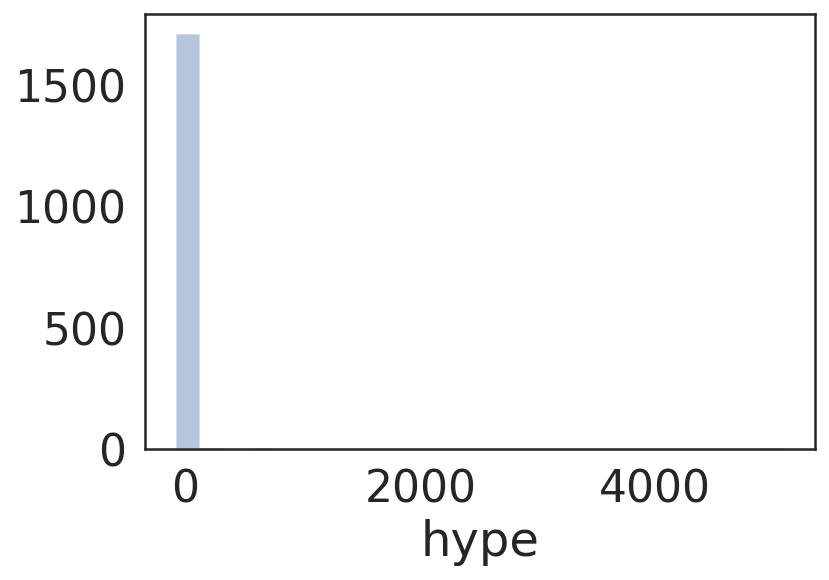

In [4]:
#Intial Look at how hype is distributed
sns.distplot(nice_df['hype'],kde=False, bins=25)

f1 = plt.gcf()

The first graph above shows us, although not informational, a histogram showing the frequency of different numbers of hype.It shows that most of our observations, almost 90% of it, are in near 0%.

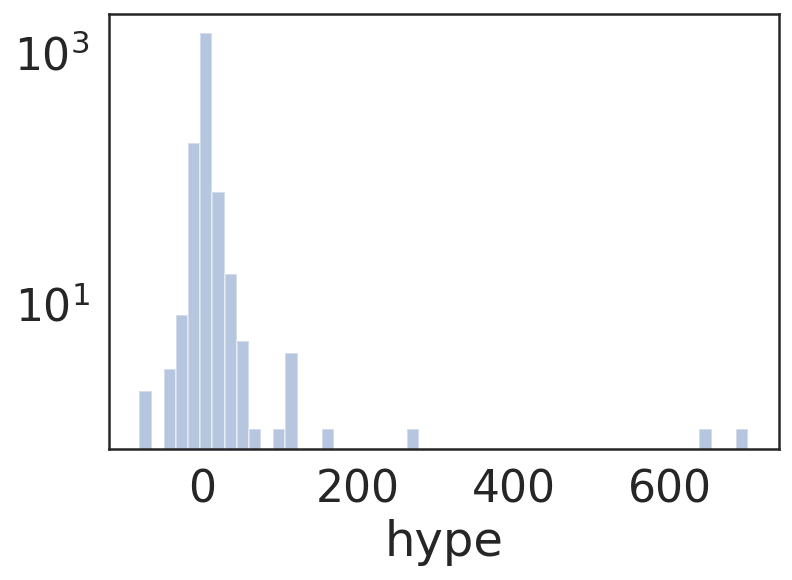

In [5]:
#Look at how hype is when y is scaled and we take all values within 1000
hype = nice_df[nice_df['hype'] < 1000]['hype']
_ = sns.distplot(hype, kde=False)
plt.yscale('log')

By cutting down some of the larger values, we are able to scale down the graph and get a better idea of how the hype is distributed. Few observations to the right, but heavuly skewed positive. Most hype values are around 0, which makes intuitive sense as only a handful of "Big-Name" companies go public.

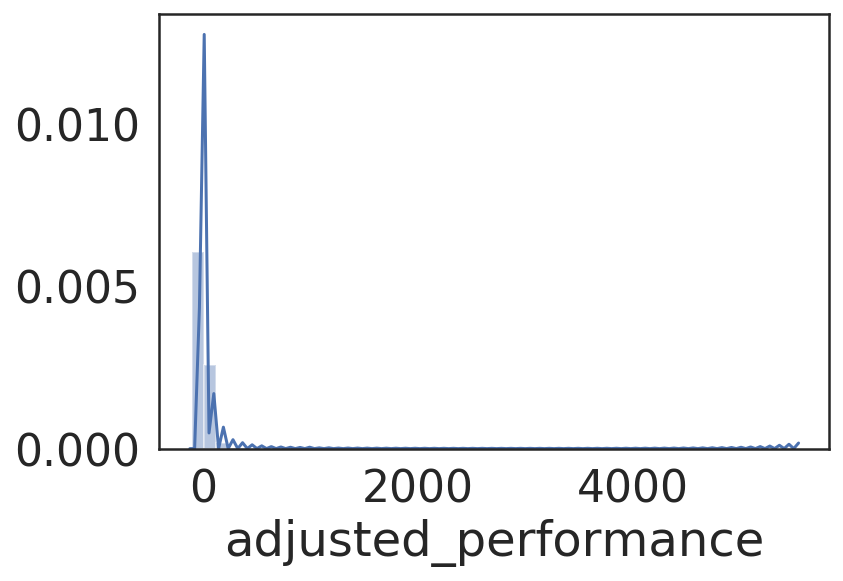

In [6]:
#Adjusted Performance is the difference between the 6 month return and the 6 month market trend.
#This shows us whether a company performance in 6 months time is performing better than the overall stock market.
sns.distplot(nice_df['adjusted_performance'])

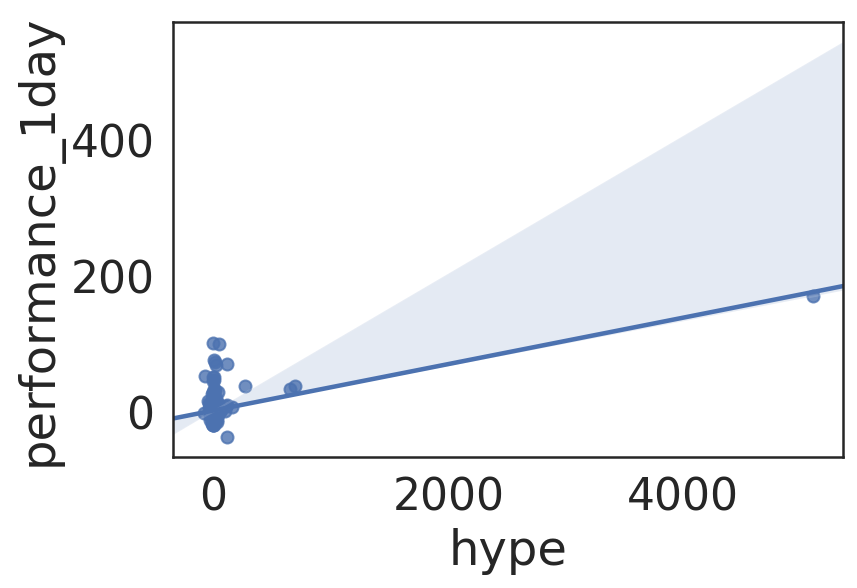

In [7]:
#Plotting to see if there is a relationship between hype and performance on the 1st day
sns.regplot(x="hype", y = 'performance_1day', data = nice_df)

f2 = plt.gcf()

By graphing a simple linear regression between hype and performance on the 1st day after IPO, we are able to see two things. Firstly, a large outlier on the right skews the data, and secondly, there does not seem to be a correlation between hype and performance on the first day.

In [8]:
#Run the summary statistics
outcome, predictors = patsy.dmatrices('performance_1day~hype',nice_df)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       performance_1day   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     648.5
Date:                Thu, 19 Mar 2020   Prob (F-statistic):          1.44e-121
Time:                        23:27:45   Log-Likelihood:                -5762.6
No. Observations:                1714   AIC:                         1.153e+04
Df Residuals:                    1712   BIC:                         1.154e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9451      0.169      5.594      0.0

The summary statistics indicate that the adjusted r squared value is 0.274, which is not a strong in-sample fit indicating that hype does not explain 1st day returns well. This is further exemplified by the fact that the t statistic accepts the null hypothesis and shows that this is not a significant predictor. However, we will examine the removal of the outlier.

In [9]:
#Indication of outlier for hype at around 3000, identify datapoint
nice_df.loc[nice_df['hype']==nice_df['hype'].max()]

,Symbol,Name,DaysBetterThanSP,daysProfit,Year,Month,MarketCap,Sector,MarketMonthTrend,Market3MonthTrend,...,performance_1wk,performance_1month,performance_2month,performance_3month,performance_4month,performance_5month,performance_6month,performance_7month,performance_8month,adjusted_performance
207,AQB,"AquaBounty Technologies, Inc.",100,262,2017,1,40567337.44,NaN,0.769115,1.267316,...,272.307692,188.461538,103.269231,60.192308,33.076923,44.230769,34.038462,17.307692,-40.384615,32.077762


We have identified AquaBounty as the outlier in our data, thus we remove it.

In [23]:
#Drop Aquabounty as it is an outlier
nice_df = nice_df[nice_df.Symbol != 'AQB']

Now we perform the OLS regression again, this time without the outlier

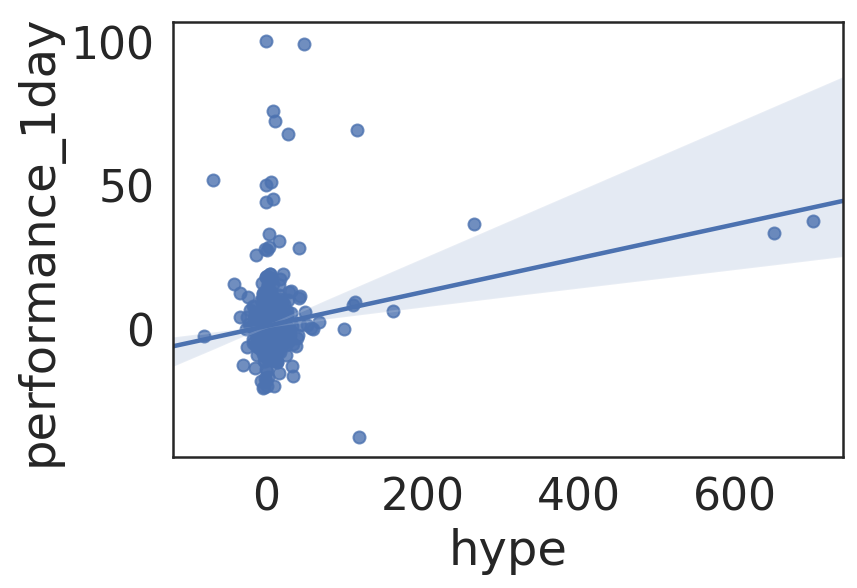

In [24]:
sns.regplot(x="hype", y = 'performance_1day', data = nice_df)

f4 = plt.gcf()

In [25]:
outcome_2, predictors_2 = patsy.dmatrices('performance_1day~hype',nice_df)
mod_2 = sm.OLS(outcome_2, predictors_2)
res_2 = mod_2.fit()
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:       performance_1day   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     84.03
Date:                Thu, 19 Mar 2020   Prob (F-statistic):           1.36e-19
Time:                        23:28:33   Log-Likelihood:                -5752.0
No. Observations:                1713   AIC:                         1.151e+04
Df Residuals:                    1711   BIC:                         1.152e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8592      0.170      5.065      0.0

We ran the OLS regression again to see if there is a better fit between hype and first day. The adjusted r squared value dropped even further to 0.046, which reflects the awful fit we see in the graph. While the P-value indicates significance, the coefficient is very small (reflecting less than 1/20th of one percent change), and it appears that this is still being influenced by further outliers with large hype values. This analysis confirms that there is no correlation between hype and first day performance, which agrees with our intuition based on visual examination of the plot.

In [26]:
nice_df["hype"].describe()

count    1713.000000
mean        3.588976
std        26.114835
min       -80.000000
25%         0.000000
50%         0.550000
75%         3.539823
max       700.000000
Name: hype, dtype: float64

Hype Rating categorizes the "hype" of an IPO into 4 separate categories, determined by the quartile ranges of the "hype" variable. Given the lack of correlation between overall hype and performance, we wanted to see if a more compelling relationship might exist between different 'levels' of hype. As is seen below though, there do not seem to be any distinguishing relationships.

In [27]:
x = lambda a: 1 if a < 0 else 2 if a < 0.549 else 3 if a < 3.54 else 4
nice_df['hype_rating'] = nice_df['hype'].apply(x)

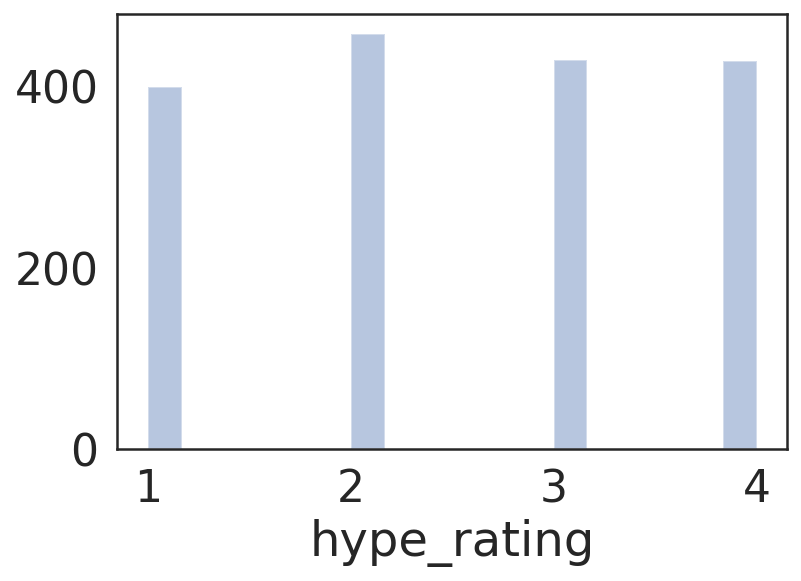

In [28]:
sns.distplot(nice_df['hype_rating'], kde=False)

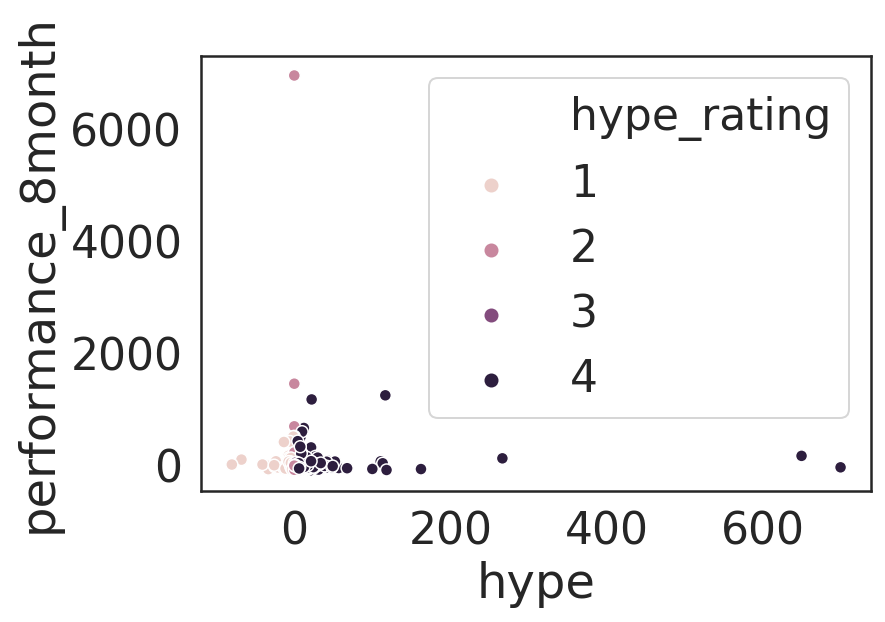

In [29]:
sns.scatterplot(nice_df['hype'], nice_df['performance_8month'], hue=nice_df['hype_rating'])

Plot hype vs 1 week, 1 month, 4 month and 8 month to see if these is a progression in distribution over equal intervals of 8 months.

Here we want to investigate whether hype is meaningfully correlated with the performance over four time intervals - one week, one month, four months, and eight months. We use the same strategy as we used previously - Ordinary Least Squares regression from statsmodels.

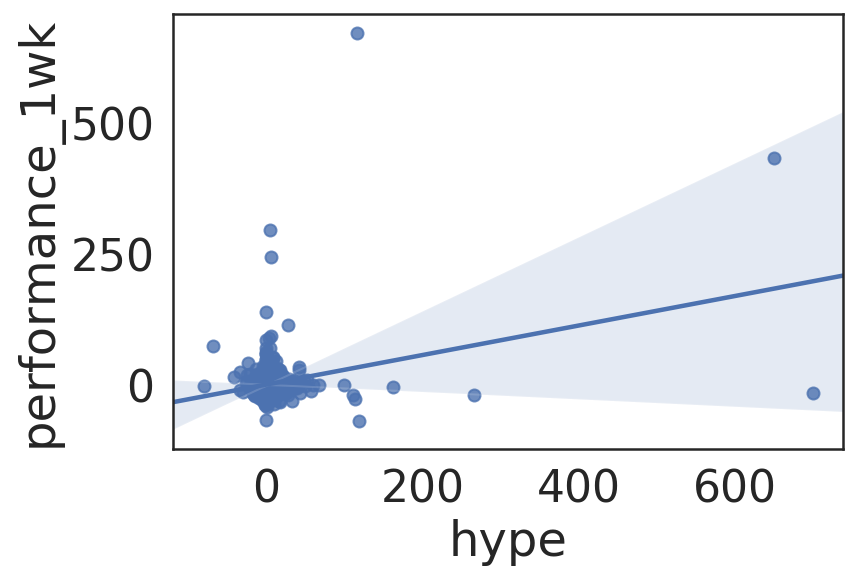

In [30]:
sns.regplot(nice_df['hype'], nice_df['performance_1wk'])

In [31]:
outcome, predictors = patsy.dmatrices('performance_1wk~hype',nice_df)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:        performance_1wk   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     170.4
Date:                Thu, 19 Mar 2020   Prob (F-statistic):           3.43e-37
Time:                        23:28:39   Log-Likelihood:                -7816.5
No. Observations:                1713   AIC:                         1.564e+04
Df Residuals:                    1711   BIC:                         1.565e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4599      0.566      2.579      0.0

For the hype ~ one week performance correlation, we get a much higher coefficient. However, the R-squared value is so low that even though the P-value indicates statistical significance, there is no meaningful correlation here.

Below are the plots and statistics for the one month, four month, and 8 month correlations - analysis follows after.

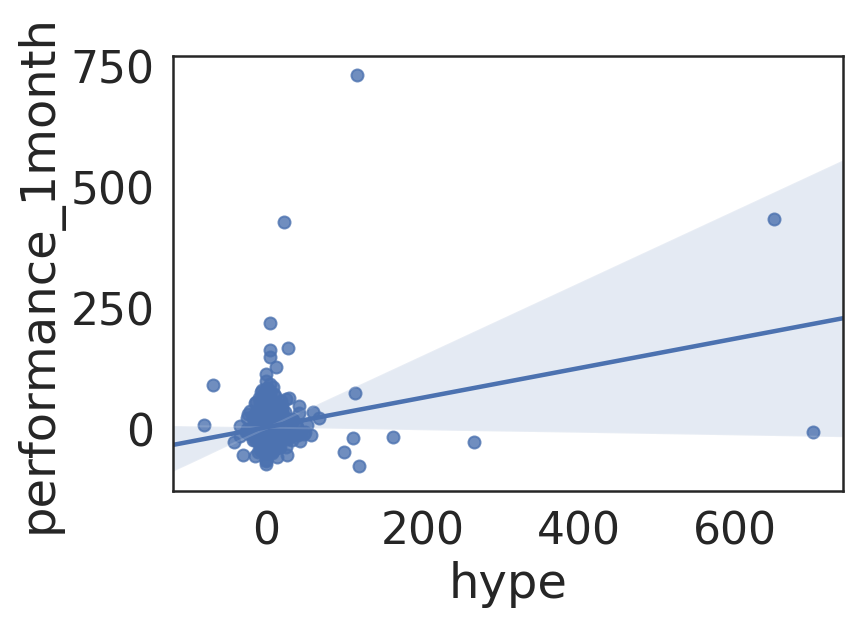

In [32]:
sns.regplot(nice_df['hype'], nice_df['performance_1month'])

In [33]:
outcome, predictors = patsy.dmatrices('performance_1month~hype',nice_df)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:     performance_1month   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     123.4
Date:                Thu, 19 Mar 2020   Prob (F-statistic):           1.00e-27
Time:                        23:28:40   Log-Likelihood:                -8238.0
No. Observations:                1713   AIC:                         1.648e+04
Df Residuals:                    1711   BIC:                         1.649e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.1642      0.724      4.370      0.0

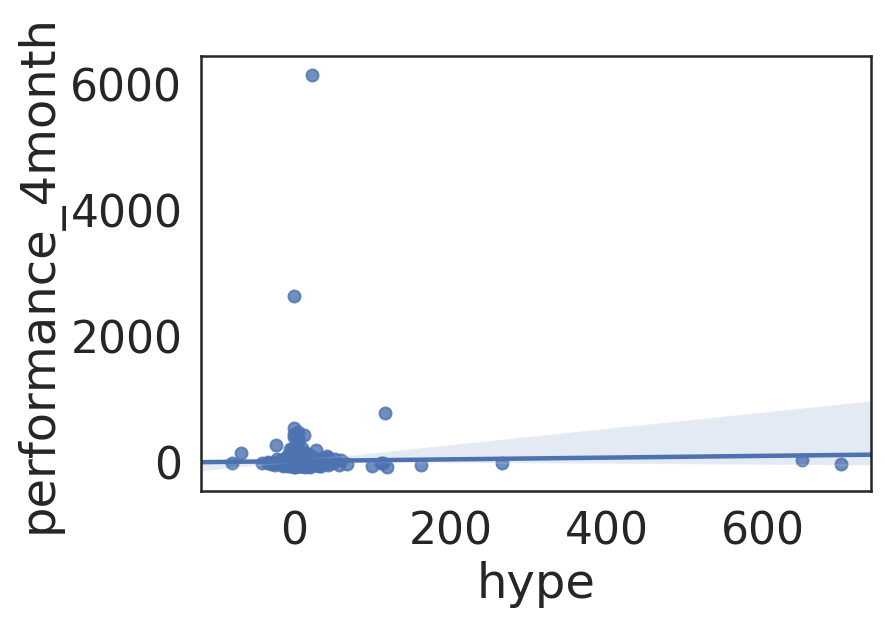

In [34]:
sns.regplot(nice_df['hype'], nice_df['performance_4month'])

In [35]:
outcome, predictors = patsy.dmatrices('performance_4month~hype',nice_df)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:     performance_4month   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7926
Date:                Thu, 19 Mar 2020   Prob (F-statistic):              0.373
Time:                        23:28:41   Log-Likelihood:                -11209.
No. Observations:                1713   AIC:                         2.242e+04
Df Residuals:                    1711   BIC:                         2.243e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.3930      4.102      3.021      0.0

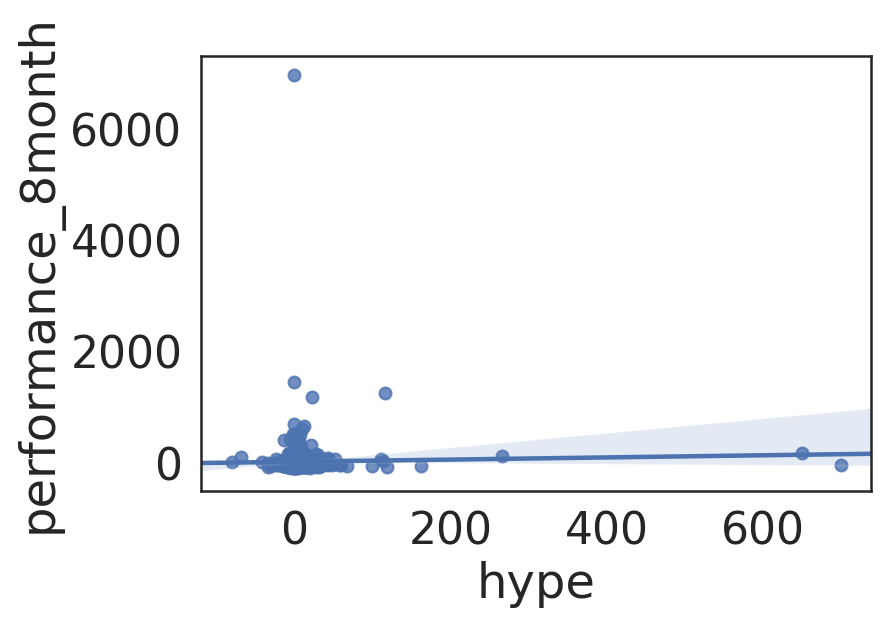

In [36]:
sns.regplot(nice_df['hype'], nice_df['performance_8month'])

In [37]:
outcome, predictors = patsy.dmatrices('performance_8month~hype',nice_df)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:     performance_8month   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.239
Date:                Thu, 19 Mar 2020   Prob (F-statistic):              0.266
Time:                        23:28:42   Log-Likelihood:                -11390.
No. Observations:                1713   AIC:                         2.278e+04
Df Residuals:                    1711   BIC:                         2.280e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.9670      4.560      3.721      0.0

Overall, we find that the R-squared values for our correlations are woefully low, and as the outliers (high performers) further diverge from the rest of the pack for the 4 month and 8 month performance values, even our P-values show that our results are not statistically meaningful.

Market 6 month trend vs performance 6 month trend shows whether or not a company outperforms the market after 6 months. This is important because instead of comparing each IPO to other IPOs between 2010 and 2018, we are able to see whether the IPO performed better or worse than the overall market. As with the rest of the 'correlations' we've looked into, there doesn't seem to be much of a trend here.

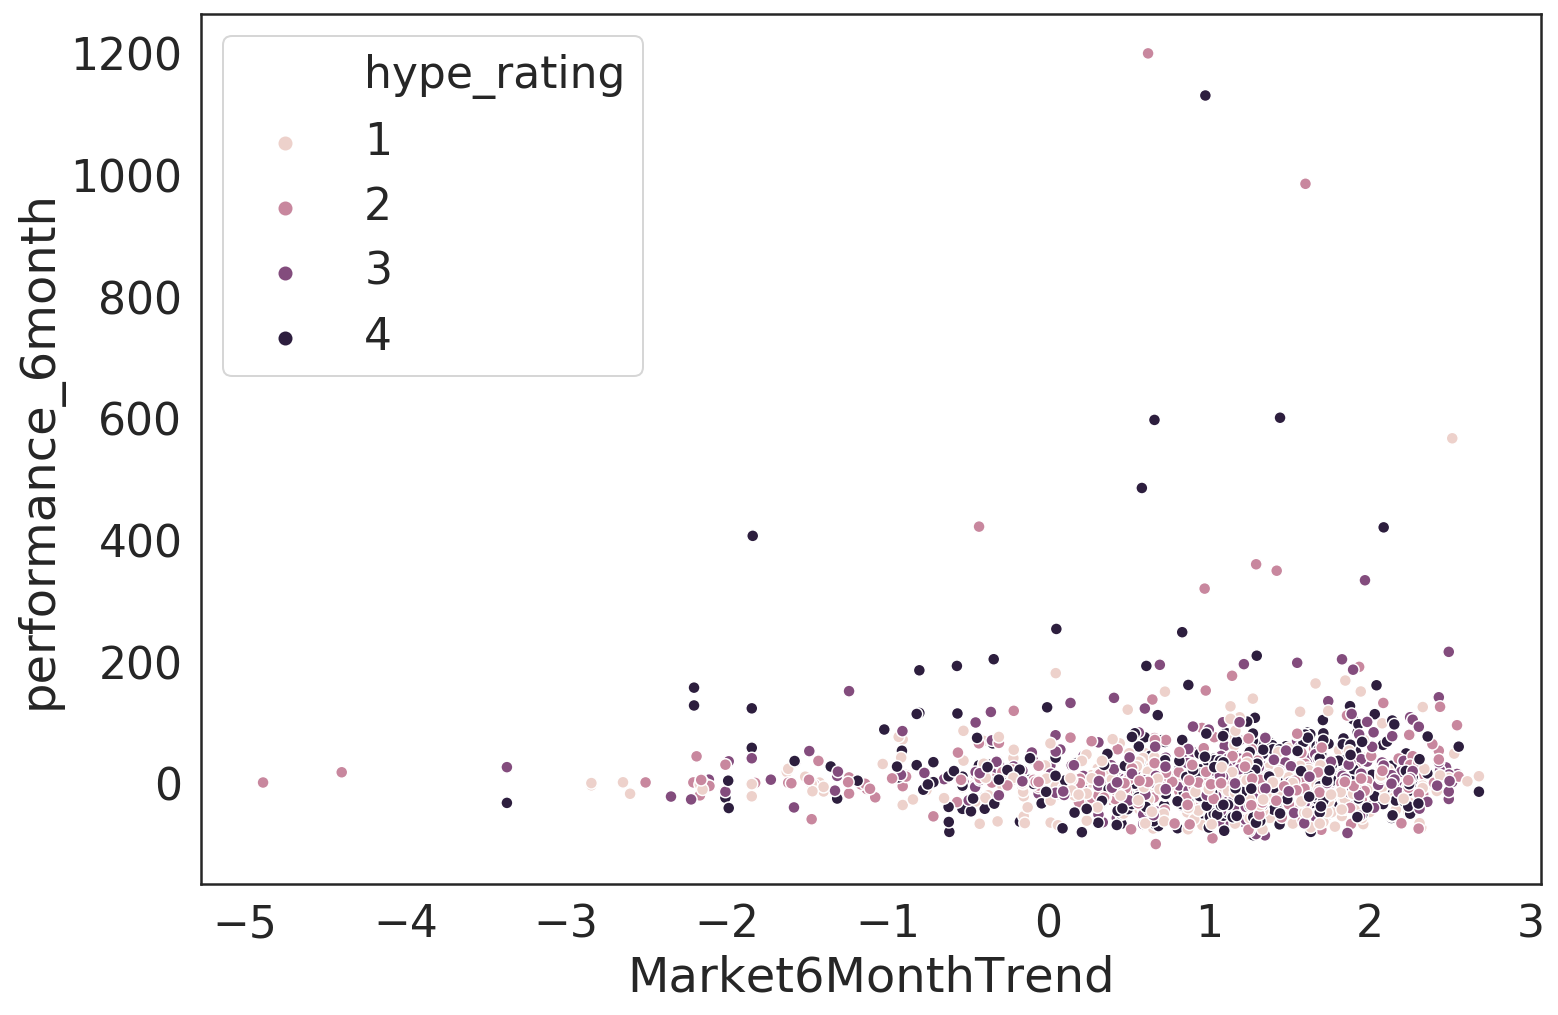

In [48]:
x = nice_df['Market6MonthTrend']
# excluding outliers that makes main body of data hard to see
y = nice_df[nice_df['performance_6month'] < 5000]['performance_6month']
plt.figure(figsize=(12,8))
sns.scatterplot(x, y, hue=nice_df['hype_rating'])

Now we look at the correlation between hype and performance by sector.

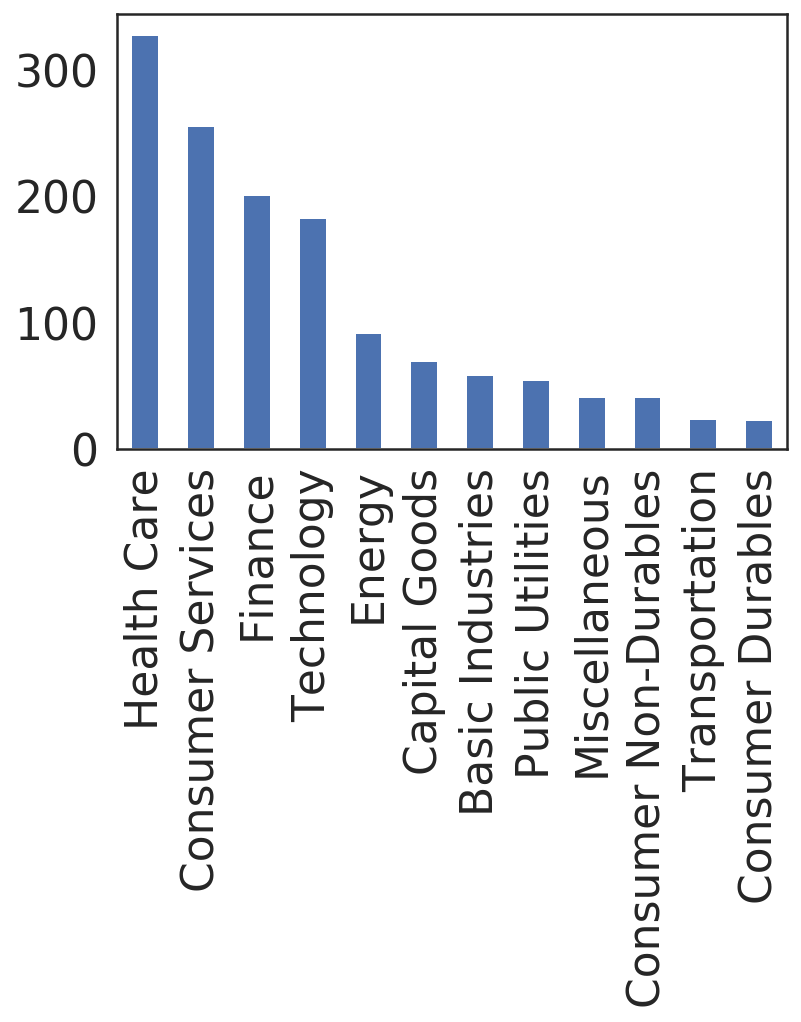

In [39]:
nice_df["Sector"].value_counts().plot.bar(x = 'Sector', y='Number of companies')

This histogram shows the frequencies of the different sectors the IPO’s in the dataset operate in. Healthcare is the highest, at over 300 observations, while Consumer Durables have the smallest amount. Companies such as Health Care, Finance, Technology and Energy require a lot of capital, compared to transportation where funding comes from government. Furthermore, due to the boom in technology and increase in demand for healthcare in recent years, it is not surprising to see such a high number of them. For our analysis here, we will only consider the categories with more than 100 data points.

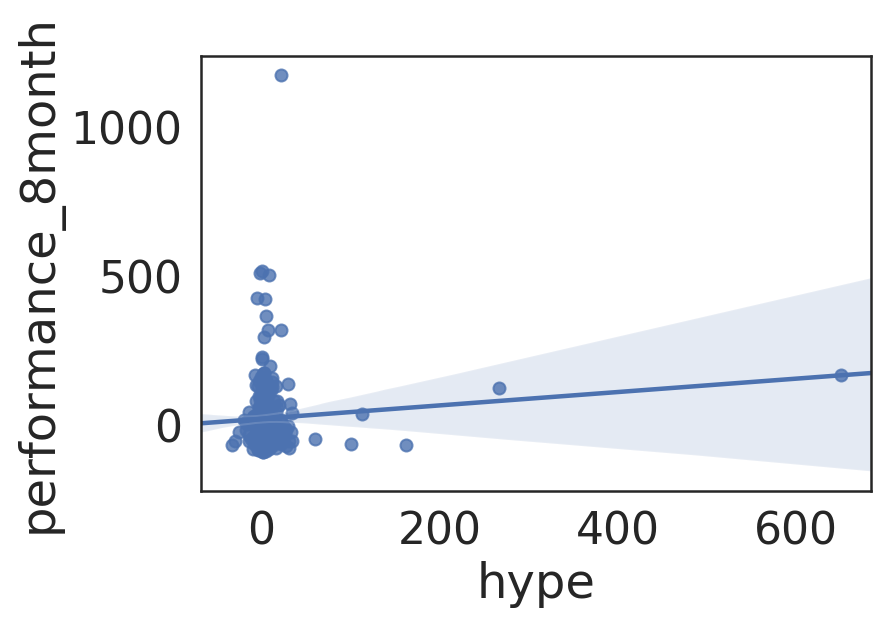

In [40]:
temp_df = nice_df[nice_df['Sector']=='Health Care']
x = temp_df['hype']
y =temp_df['performance_8month']

sns.regplot(x, y)

In [41]:
outcome, predictors = patsy.dmatrices('performance_8month~hype',temp_df)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:     performance_8month   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.268
Date:                Thu, 19 Mar 2020   Prob (F-statistic):              0.133
Time:                        23:28:58   Log-Likelihood:                -2010.9
No. Observations:                 328   AIC:                             4026.
Df Residuals:                     326   BIC:                             4033.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     18.7738      6.256      3.001      0.0

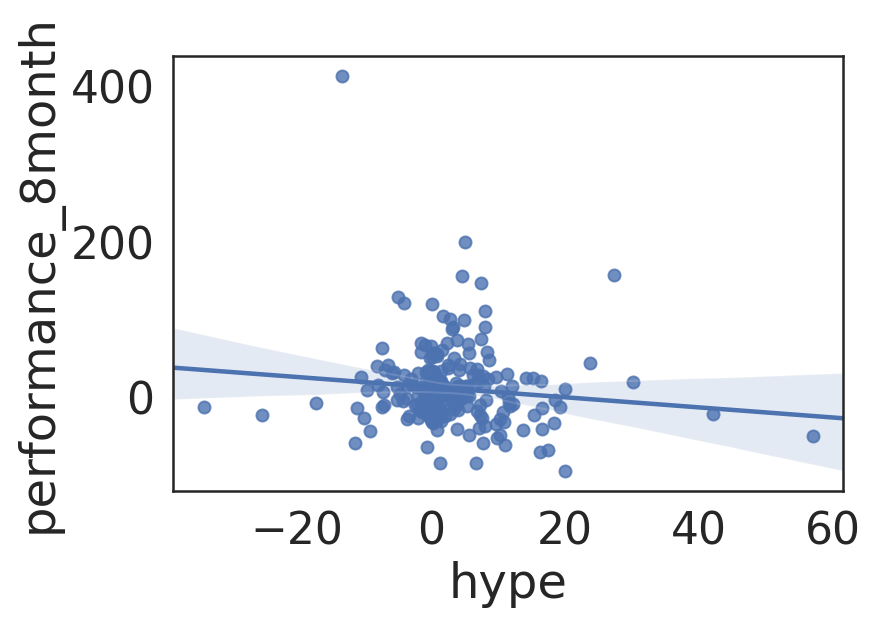

In [42]:
temp_df = nice_df[nice_df['Sector']=='Consumer Services']
x = temp_df['hype']
y =temp_df['performance_8month']

sns.regplot(x, y)

In [43]:
outcome, predictors = patsy.dmatrices('performance_8month~hype',temp_df)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:     performance_8month   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     3.215
Date:                Thu, 19 Mar 2020   Prob (F-statistic):             0.0742
Time:                        23:28:59   Log-Likelihood:                -1350.6
No. Observations:                 256   AIC:                             2705.
Df Residuals:                     254   BIC:                             2712.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.8692      3.129      4.113      0.0

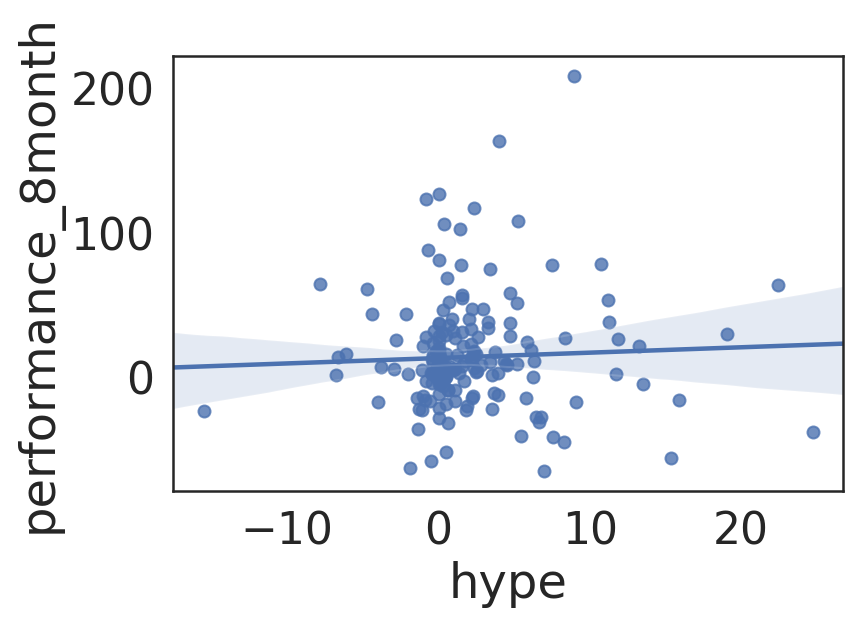

In [44]:
temp_df = nice_df[nice_df['Sector']=='Finance']
x = temp_df['hype']
y =temp_df['performance_8month']

sns.regplot(x, y)

In [45]:
outcome, predictors = patsy.dmatrices('performance_8month~hype',temp_df)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:     performance_8month   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.4313
Date:                Thu, 19 Mar 2020   Prob (F-statistic):              0.512
Time:                        23:29:00   Log-Likelihood:                -1007.5
No. Observations:                 201   AIC:                             2019.
Df Residuals:                     199   BIC:                             2026.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.9131      2.782      4.642      0.0

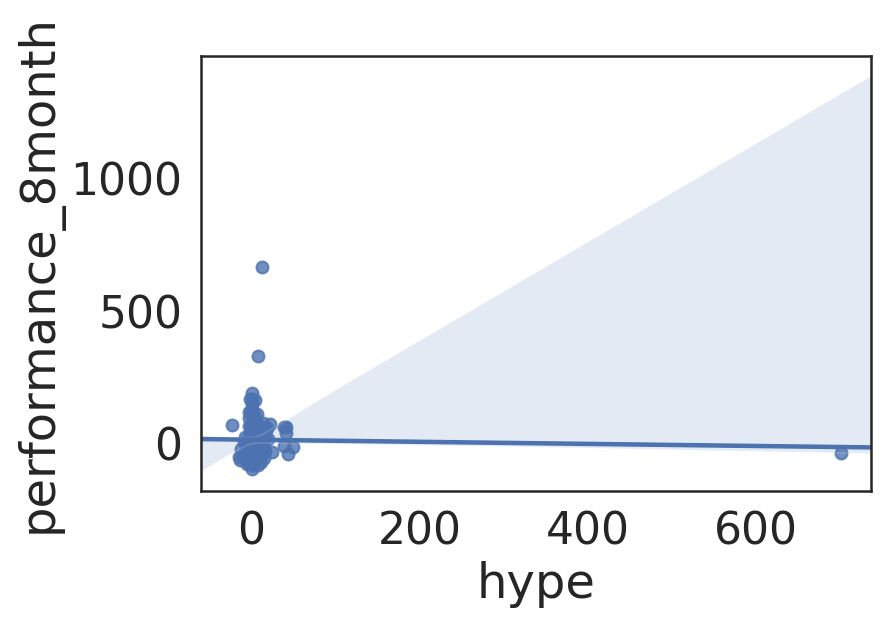

In [46]:
temp_df = nice_df[nice_df['Sector']=='Technology']
x = temp_df['hype']
y =temp_df['performance_8month']

sns.regplot(x, y)

In [47]:
outcome, predictors = patsy.dmatrices('performance_8month~hype',temp_df)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:     performance_8month   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.1337
Date:                Thu, 19 Mar 2020   Prob (F-statistic):              0.715
Time:                        23:29:01   Log-Likelihood:                -1051.8
No. Observations:                 183   AIC:                             2108.
Df Residuals:                     181   BIC:                             2114.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.4492      5.699      2.185      0.0

Our least squares regressions on the eight-month performance versus hype by sector yielded similar results to our previous invstigations. None of the P-values for these regressions by sector indicate that a statistically significant relationship exists when testing on a 95% confidence interval, and the R-squared values are all less than 0.01.

## Ethics and Privacy

As in any data science study, it is important to carefully consider any biases that informed the intent and design of this study, and what ethical precautions may potentially be violated at each step in the data science process. Data for this study was taken from all IPOs in the US between the years 2010 and 2019. 2010 was chosen as a starting point becuase most economists agree that that is when the effects of the 2008 recession began to taper off. Even though we standardized our data, we did not want to risk invalidating our results with confounds or market biases caused the recession. The intent of this study was non-harmful, and precuations were taken to not deliberately breach objectivity; nevertheless, a discussion of potential ethical concerns at each step is included here.

The Question: Our research seeks to answer the question of whether or not IPO hype (as indicated by first day stock performance) is in any way predictive of long term company success (measured by stock value at the end of eight months).  While the dataset in question is inclusive in that it contains businesses from different sectors, run by CEOs of different races and genders, etc., it is not possible to account for ALL potential correlates that may be inadvertantly tracked. However, the question itself is framed in an unbiased way, and does not seek to make unecessary or unethical conclusions. _(see Analysis section for elaboration on possibly unethical results)_ 

The Implications: If the results of this study did end up showing a significant outcome, it could be potentially damaging to companies that do not perform in the range of predictive success on their first day, because people who come across  this research would be inclined not to invest in them. Our results do not reveal sufficient evidence that a IPO hype dependent predictive model exists. Even if it did, we would be careful to emphasize that such trends are merely generalizations and cannot accurately predict how any one given stock will behave, so the financial decisions of companies and investors should ideally be informed by more than just the outcome of this study.

The Data: The dataset used for this study is publicly available and related directly ro out research question. At over 3000 rows of data, there is enough data to make fairly reliable inferences regarding companies' stock trends over the course of eight months. Analysis of the data does not reveal any glaring biases or inconsistencies; however, there were a couple of outliers that were carefully examined. These outliers were dropped once it was reliably shown that they were the result of individual company decisions or randomness in the stock market, and not a manifestation of socio-economic biases.

Informed Consent: While each individual company was not personally contacted for consent, the data analyzed was taken from a public online database. Additionally, corporations and company information are not subject to the same privacy concerns as people and personally identifiable information (PII). Thus, given the freely available database and the unbiased nature of the question, the corporation equivalent of informed consent can be assumed.

Privacy: In the data visualizations, identifiable information like the company name, IPO year, etc. are not shown. However, it si possible to use the dataset above to match data points in the visualizations to individual companies. Assumptions about the relative vulnerability of different companies (based on factors such as race/ethnicity of CEO, gender, etc.) can also be made by the general public, should they come across this research or the dataset it was derived from. The aim of this study was not to prove or disprove any such assumptions, and while we cannot guarantee privacy, we do offer the disclaimer that financial decisions should not be made based on the results of this study alone, because no strong predictive correlations were found between IPO hype and long term stock market success of a company.

Evaluation: This study does have a quantitative, verifiable metric of success: the change in closing price of the company's stock by the 240th day post-IPO. Because this is a one-time study and the eight-month price change is not a recurring measurement, there is minimal danger of violating Goodhart's Law and allowing the above metric to become a target. The average price increase in the first eight months is not a variable that is analyzed in this study; therefore, there is no reason a company that comes across this study would be concerned that they are somehow not meeting a minimum criterion for success.

Analysis: The aim of this study is not to determine causation; rather, it seeks to understand if there is a potential predictive correlation between IPO hype and the eight-month market gains of a company. The results of the analysis do not show a conclusive correlation, and there is no clearl group splitting of the data in the various visualizations. This indicates that it is unlikely that unanticipated covariates are being tracked.

Transparency and Appeal: As mentioned, the appearance of general trends do not predict the outcome of any one individual variable; in this case, any potential correlations cannot reliably determine how a specific given company will perform. Thus, there is plenty of room for appeal. The process used to come to the conclusions below has been detailed earlier in this report; however, the results demonstrate that a clear pattern between the variable in question does not exist.

Continuous Monitoring: This study has been conducted using data from 2010-2019, during a period of relatively steady economic growth. It is difficult to replicate the study, because as of late, the stock market is not doing well, and we may be headed for another recession. However, data from current times can be input into the process above to see if different base stock market trends affect the strength and direction of a correlation between IPO hype and long-term company success.

## Conclusion and Discussion

Overall, our investigation has shown that no clear relationship exists between the first-day pricing 'hype' of an IPO and its performance from the next day up to its eighth month on the stock market. Even when specifying sectors and separating the IPOs by first day performance level, no meaningful relationship seems to exist. Although we secretly hoped to come away from this project with a neat 'get rich quick' strategy, it seems we can't rely on the hype! This gives us a disappointing answer to our question, “Does first day pricing hype of an IPO correlate with stock market performance?"  Unfortunately not. Our research confirms the age-old value investing principle, “the market has no patterns”. 

We hypothesized that IPO hype would be a strong negative predictor of stock performance by the end of the eight months, meaning that strong hype leads to worse overall performance. However, our results proved different, as no correlation was seen between the two. It was also proven that hype was not an indicator in anytime between its first release until the end of the eighth week. 

Our analysis was in part limited by the availability of data - in future work, the definition of 'hype' should be explored further with factors beyond the price of the IPO, which could potentially yield a richer analysis with new relationships exposed.

Therefore, the conclusion of our research for budding investors is to not follow the hype, and make sure to do your own research before investing your money.